# Analyze template coadds for Run2.1i

In [3]:
import os
import sys
import numpy as np

In [4]:
import pandas as pd

In [5]:
from astropy.coordinates import SkyCoord
import astropy.units as u

In [6]:
import lsst.afw.display as afwDisplay
import lsst.afw.geom as afwGeom
import lsst.afw.display.ds9 as ds9
import lsst.afw.image as afwImage
from lsst.daf.persistence import Butler
from lsst.geom import SpherePoint
import lsst.geom

In [7]:
# Requires issues/337 to fix obshistid query.
sys.path.insert(0, '/global/homes/b/bos0109/desc/gcr-catalogs')

In [8]:
import GCRCatalogs

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6, 6)
plt.rcParams['font.size'] = 14
#from matplotlib.patches import Polygon

In [10]:
import dm_utilities as dmu

import importlib
importlib.reload(dmu)

<module 'dm_utilities' from '/global/u2/b/bos0109/run2_diaproc/dm_utilities.py'>

In [11]:
repo = '/global/cscratch1/sd/bos0109/templates_003/rerun/multiband/'
#repo = '/global/cscratch1/sd/bos0109/templates_004/rerun/multiband'

In [12]:
butler = Butler(repo)

In [13]:
tract = 4640
patch = (6, 0)

In [14]:
tract = 4639
patch = (0, 0)

In [15]:
skymap = butler.get('deepCoadd_skyMap')
tract_info = skymap[tract]

In [16]:
tract_info

TractInfo(id=4639, ctrCoord=[0.4780489378485402, 0.7168940640771417, -0.5074762200466556])

In [17]:
tract_patch_box = tract_info.getPatchInfo(patch).getOuterBBox()
tract_patch_pos_list = tract_patch_box.getCorners()
# Cast to Point2D, because pixelToSky below will refuse to work with a Point2I object.
tract_patch_pos_list = [afwGeom.Point2D(tp) for tp in tract_patch_pos_list]

wcs = tract_info.getWcs()
corners = wcs.pixelToSky(tract_patch_pos_list)
corners = np.array([[c.getRa().asDegrees(), c.getDec().asDegrees()] for c in corners])

In [18]:
ra = corners[:, 0]
dec = corners[:, 1]
min_ra, max_ra = np.min(ra), np.max(ra)
min_dec, max_dec = np.min(dec), np.max(dec)

In [19]:
print(min_ra, max_ra, min_dec, max_dec)

56.945218354752335 57.21309460920186 -31.271939290368756 -31.04267436934138


What is the approximated area of this polygon?

In [20]:
delta_ra, delta_dec = max_ra-min_ra, max_dec-min_dec

In [21]:
area = np.cos(np.deg2rad(min_dec+delta_dec*0.5))*np.deg2rad(delta_ra)*np.deg2rad(delta_dec)*180.*180./(np.pi**2.)*u.deg*u.deg

In [22]:
print(area, ',', area.to(u.arcmin**2))

0.0525555696255307 deg2 , 189.20005065191054 arcmin2


In [23]:
print((delta_ra*u.deg).to(u.arcmin), (delta_dec*u.deg).to(u.arcmin))

16.07257526697154 arcmin 13.75589526164255 arcmin


Now we have done exactly the same stuff as in other notebooks but for our templates

### Exploring corners and t+p positions

Center

In [24]:
dmu.get_coadd_id_for_ra_dec(skymap, min_ra+delta_ra/2., min_dec+delta_dec/2.)

{'tract': 4639, 'patch': '0,0'}

Corners

In [25]:
dmu.get_coadd_id_for_ra_dec(skymap, min_ra, min_dec)

{'tract': 4432, 'patch': '5,6'}

In [26]:
dmu.get_coadd_id_for_ra_dec(skymap, min_ra, max_dec)

{'tract': 4639, 'patch': '1,1'}

In [27]:
dmu.get_coadd_id_for_ra_dec(skymap, max_ra, min_dec)

{'tract': 4432, 'patch': '4,6'}

In [28]:
dmu.get_coadd_id_for_ra_dec(skymap, max_ra, max_dec)

{'tract': 4640, 'patch': '6,1'}

Questions for this set of templates:
* Which visits were coadded in each filter?
* Which is the limiting magnitude for each template?
* Which is the seeing for each template?

In [29]:
#tpId = {'tract': 4640, 'patch': '6,0'}
tpId = {'tract': 4639, 'patch': '0,0'}

In [30]:
coaddMapper = butler._getDefaultMapper()

In [31]:
mapper = coaddMapper(root=repo)
all_dataset_types = mapper.getDatasetTypes()

remove = ['_config', '_filename', '_md', '_sub', '_len', '_schema', '_metadata']

shortlist = []
for dataset_type in all_dataset_types:
    keep = True
    for word in remove:
        if word in dataset_type:
            keep = False
    if keep:
        shortlist.append(dataset_type)

#print(shortlist)

In [32]:
ls /global/cscratch1/sd/bos0109/templates_004/rerun/multiband/deepCoadd-results/

g/  i/  merged/  r/  u/  y/  z/


In [33]:
cat /global/cscratch1/sd/bos0109/templates_004/rerun/multiband/repositoryCfg.yaml

!RepositoryCfg_v1
_mapper: !!python/name:lsst.obs.lsst.imsim.ImsimMapper ''
_mapperArgs: {}
_parents:
- ../..
_policy: null
_root: null
dirty: true


In [34]:
butler.getKeys('deepCoadd_calexp')

{'filter': str, 'tract': int, 'patch': str}

In [35]:
cvi = butler.queryMetadata('calexp', ['id', 'visit', 'filter'], dataId=tpId)

In [36]:
butler.datasetExists('calexp', dataId=tpId)

False

In [37]:
merged_sources = butler.get('deepCoadd_mergeDet', dataId=tpId).asAstropy()

In [38]:
merged_sources.colnames

['id',
 'coord_ra',
 'coord_dec',
 'parent',
 'merge_footprint_i',
 'merge_footprint_r',
 'merge_footprint_z',
 'merge_footprint_y',
 'merge_footprint_g',
 'merge_footprint_u',
 'merge_footprint_sky']

## Inspecting the SNe that fall in this Patch

In [39]:
import sqlite3

In [40]:
database = '/global/cscratch1/sd/bos0109/sne_params_cosmoDC2_v1.1_181121.db'

conn = sqlite3.connect(database)
c = conn.cursor()

In [41]:
query = "SELECT * FROM sne_params WHERE snra_in > {} AND snra_in < {} AND sndec_in > {} AND sndec_in < {}".format(min_ra, max_ra, min_dec, max_dec)

In [42]:
print(query)

SELECT * FROM sne_params WHERE snra_in > 56.945218354752335 AND snra_in < 57.21309460920186 AND sndec_in > -31.271939290368756 AND sndec_in < -31.04267436934138


In [43]:
sntab = pd.read_sql_query(query, conn)

In [44]:
len(sntab)

59

In [45]:
sntab.columns

Index(['htmid_level_6', 'galaxy_id', 'c_in', 'mB', 't0_in', 'x0_in', 'x1_in',
       'z_in', 'snid_in', 'snra_in', 'sndec_in'],
      dtype='object')

Text(0, 0.5, '$\\delta$')

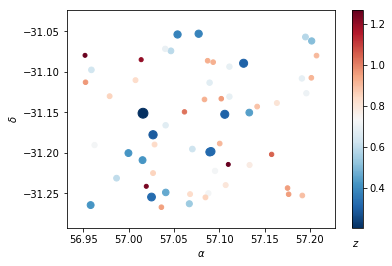

In [46]:
plt.scatter(sntab.snra_in, sntab.sndec_in, s=20/sntab.z_in, c=sntab.z_in, cmap='RdBu_r')

clb = plt.colorbar()
clb.set_label(r'$z$', labelpad=-30, y=-0.05, rotation=0)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\delta$')

In [47]:
from astropy import time

In [48]:
t0 = time.Time(sntab.t0_in, format='mjd', scale='utc')

/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


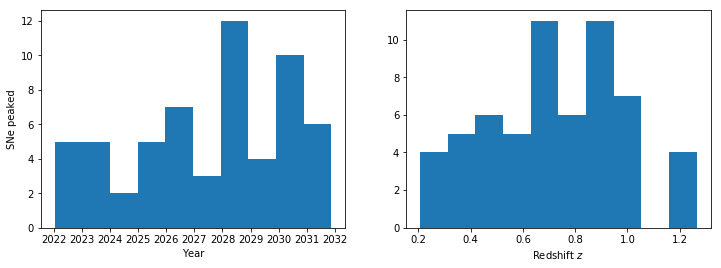

In [49]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.hist(t0.datetime64, cumulative=False)
plt.xlabel('Year')
plt.ylabel('SNe peaked')

plt.subplot(122)
plt.hist(sntab.z_in, cumulative=False)
plt.xlabel(r'Redshift $z$')
plt.show()

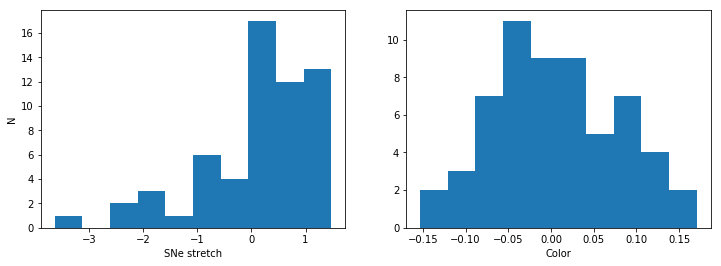

In [50]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.hist(sntab.x1_in, cumulative=False)
plt.ylabel('N')
plt.xlabel('SNe stretch')

plt.subplot(122)
plt.hist(sntab.c_in, cumulative=False)
plt.xlabel(r'Color')
plt.show()

In [51]:
sntab.to_csv('./supernovae_cat_t4639_p00.csv')

## Using the SN coordinates to look into the templates

In [52]:
import importlib

In [53]:
importlib.reload(dmu)

<module 'dm_utilities' from '/global/u2/b/bos0109/run2_diaproc/dm_utilities.py'>

In [54]:
ra, dec = sntab.snra_in[1], sntab.sndec_in[1]

In [55]:
im = butler.get('deepCoadd', {'patch': '0,0' , 'filter':'r' , 'tract':4639})

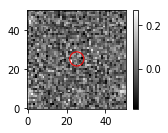

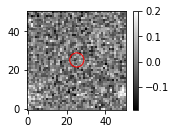

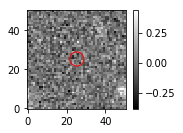

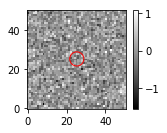

In [56]:
frame = 0
plt.figure(frame)

plt.subplot(221)
cutout = dmu.make_cutout_image(butler, ra, dec, filter='g')

plt.subplot(222)
cutout = dmu.make_cutout_image(butler, ra, dec, filter='r')

plt.subplot(223)
cutout = dmu.make_cutout_image(butler, ra, dec, filter='i')

plt.subplot(224)
cutout = dmu.make_cutout_image(butler, ra, dec, filter='z')

<Figure size 432x288 with 0 Axes>

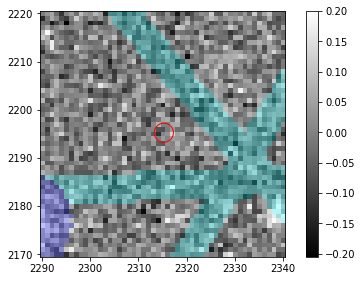

In [57]:
frame = 1
plt.figure(frame)
cutout = dmu.display_cutout_image(butler, sntab.snra_in[1], sntab.sndec_in[1])

## The DIA sources inspection

In [58]:
diarepo = '/global/cscratch1/sd/bos0109/test_imdiff_run2/rerun/multiband/rerun/forcedPhot/'

In [59]:
butlerdia = Butler(diarepo)

<Figure size 432x288 with 0 Axes>

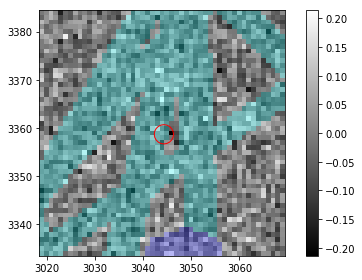

In [60]:
frame = 1
plt.figure(frame)
cutout = dmu.display_cutout_image(butlerdia, sntab.snra_in[3], sntab.sndec_in[3])

In [61]:
diaMapper = butlerdia._getDefaultMapper()

In [62]:
diamapper = diaMapper(diarepo)

In [63]:
all_diadataset_types = diamapper.getDatasetTypes()

remove = ['_config', '_filename', '_md', '_sub', '_len', '_schema', '_metadata']

shortlist = []
for dataset_type in all_diadataset_types:
    keep = True
    for word in remove:
        if word in dataset_type:
            keep = False
    if keep:
        shortlist.append(dataset_type)

#print(shortlist)

In [64]:
butlerdia.datasetExists('deepDiff_diaSrc')

False

In [65]:
butlerdia.getKeys('deepDiff_diaSrc')

{'visit': int,
 'filter': str,
 'raftName': str,
 'detectorName': str,
 'detector': int}

In [66]:
tpId = {'tract':4639, 'patch': '0,0'}

In [67]:
metadata = butlerdia.queryMetadata('deepDiff_diaSrc', ['id', 'visit', 'filter', 'raftName', 'detectorName', 'detector'],
                                   dataId=tpId)

In [73]:
meta = pd.DataFrame(metadata, columns=['id', 'visit', 'filter', 'raftName', 'detectorName', 'detector'])

In [74]:
meta.head()

,id,visit,filter,raftName,detectorName,detector
0,1,12469,y,R24,S01,109
1,2,12469,y,R24,S02,110
2,3,12469,y,R24,S10,111
3,4,12469,y,R24,S11,112
4,5,12469,y,R24,S12,113


In [76]:
meta = meta[meta['filter']!='u']
meta = meta[meta['filter']!='y']

In [78]:
path = '/global/cscratch1/sd/bos0109/test_imdiff_run2/deepDiff'
diffpath = 'v{}-f{}/{}/diaSrc_{}-{}-{}-{}-det{}.fits'

cats = []
for idx, vn, fna, raf, detN, det in metadata:
    if fna=='y' or fna=='u': continue
    
    dpath = os.path.join(path, diffpath.format(str(vn).zfill(8), fna, raf, 
                                               str(vn).zfill(8), fna,raf, detN, 
                                               str(det).zfill(3)))
    if os.path.exists(dpath):
        catalog=butlerdia.get('deepDiff_diaSrc', visit=vn,detector=det).asAstropy()
        if len(catalog) is not 0:
            catalog['visit_n'] = vn
            catalog['filter'] = fna
            catalog['raft'] = raf
            catalog['sensor'] = detN
            catalog['detector'] = det

            cats.append(catalog)

In [79]:
ls /global/cscratch1/sd/bos0109/test_imdiff_run2/deepDiff/v00159481-fg/R02/

diaSrc_00159481-g-R02-S11-det013.fits  diffexp_00159481-g-R02-S11-det013.fits
diaSrc_00159481-g-R02-S21-det016.fits  diffexp_00159481-g-R02-S21-det016.fits


In [80]:
from astropy.table import vstack

In [81]:
mastercat = vstack(cats)

In [84]:
butlerdia.getKeys('deepDiff_diaObject')

{'tract': int, 'patch': str}

In [85]:
objs = butlerdia.get('deepDiff_diaObject', dataId=tpId).asAstropy()

In [86]:
len(objs)

958

In [87]:
sn_truth_t = pd.read_csv('SN_Truth_table.csv')

In [92]:
sn_truth_t['snid_in'] = sn_truth_t.snid_in.astype(str)

In [131]:
sn_truth_t['snid_in_cat'] = sn_truth_t.snid_in.astype('category')

In [108]:
sn_truth_t = sn_truth_t.astype({'snid_in': 'str'})

In [132]:
sntab['snid_in_cat'] = sntab.snid_in.astype('category')

In [116]:
sntab = sntab.astype({'snid_in': 'str'})

In [127]:
sn_truth_t.astype({'snid_in': 'str'}).dtypes

index                 int64
fieldID               int64
descDitheredRA      float64
descDitheredDec     float64
expMJD              float64
filter               object
fiveSigmaDepth      float64
fiveSigmaDepth.1    float64
rotSkyPos           float64
rotTelPos           float64
FWHMeff             float64
obsHistID             int64
mag                 float64
snid_in              object
chip                 object
xpixel              float64
ypixel              float64
dtype: object

In [95]:
len(sn_truth_t)

1809

In [96]:
len(mastercat)

6127

In [101]:
sn_truth_t.columns

Index(['index', 'fieldID', 'descDitheredRA', 'descDitheredDec', 'expMJD',
       'filter', 'fiveSigmaDepth', 'fiveSigmaDepth.1', 'rotSkyPos',
       'rotTelPos', 'FWHMeff', 'obsHistID', 'mag', 'snid_in', 'chip', 'xpixel',
       'ypixel'],
      dtype='object')

In [115]:
sntab.columns

Index(['htmid_level_6', 'galaxy_id', 'c_in', 'mB', 't0_in', 'x0_in', 'x1_in',
       'z_in', 'snid_in', 'snra_in', 'sndec_in'],
      dtype='object')

In [110]:
merged = pd.merge(left=sn_truth_t, right=sntab, how='left', on='snid_in', suffixes=('_tab', '_par'))

In [129]:
merged

,index,fieldID,descDitheredRA,descDitheredDec,expMJD,filter,fiveSigmaDepth,fiveSigmaDepth.1,rotSkyPos,rotTelPos,...,htmid_level_6,galaxy_id,c_in,mB,t0_in,x0_in,x1_in,z_in,snra_in,sndec_in
0,107,1297,57.951252,-31.295413,60132.418248,lssty,22.135284,22.135284,2.065568,0.262857,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,107,1297,57.951252,-31.295413,60132.418248,lssty,22.135284,22.135284,2.065568,0.262857,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,107,1297,57.951252,-31.295413,60132.418248,lssty,22.135284,22.135284,2.065568,0.262857,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,107,1297,57.951252,-31.295413,60132.418248,lssty,22.135284,22.135284,2.065568,0.262857,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,107,1297,57.951252,-31.295413,60132.418248,lssty,22.135284,22.135284,2.065568,0.262857,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,107,1297,57.951252,-31.295413,60132.418248,lssty,22.135284,22.135284,2.065568,0.262857,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,108,1297,58.944666,-30.814988,60145.374232,lsstg,24.418622,24.418622,2.866696,1.047071,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,108,1297,58.944666,-30.814988,60145.374232,lsstg,24.418622,24.418622,2.866696,1.047071,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,108,1297,58.944666,-30.814988,60145.374232,lsstg,24.418622,24.418622,2.866696,1.047071,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,108,1297,58.944666,-30.814988,60145.374232,lsstg,24.418622,24.418622,2.866696,1.047071,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [114]:
np.sum(merged['x0_in'].notnull())

0

In [99]:
mastercat.colnames

['id',
 'coord_ra',
 'coord_dec',
 'parent',
 'flags_negative',
 'base_NaiveCentroid_x',
 'base_NaiveCentroid_y',
 'base_NaiveCentroid_flag',
 'base_NaiveCentroid_flag_noCounts',
 'base_NaiveCentroid_flag_edge',
 'base_NaiveCentroid_flag_resetToPeak',
 'base_PeakCentroid_x',
 'base_PeakCentroid_y',
 'base_PeakCentroid_flag',
 'base_SdssCentroid_x',
 'base_SdssCentroid_y',
 'base_SdssCentroid_xErr',
 'base_SdssCentroid_yErr',
 'base_SdssCentroid_flag',
 'base_SdssCentroid_flag_edge',
 'base_SdssCentroid_flag_noSecondDerivative',
 'base_SdssCentroid_flag_almostNoSecondDerivative',
 'base_SdssCentroid_flag_notAtMaximum',
 'base_SdssCentroid_flag_resetToPeak',
 'ip_diffim_NaiveDipoleCentroid_flag',
 'base_CircularApertureFlux_flag_badCentroid',
 'base_GaussianFlux_flag_badCentroid',
 'base_NaiveCentroid_flag_badInitialCentroid',
 'base_PeakLikelihoodFlux_flag_badCentroid',
 'base_PsfFlux_flag_badCentroid',
 'base_SdssCentroid_flag_badInitialCentroid',
 'base_SdssShape_flag_badCentroid',
 '